In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import warnings
import pymc as pm
import arviz as az
import bambi as bmb

# Plot settings
plt.style.use(
    "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
)
az.style.use("arviz-darkgrid")

# Pandas: Set max rows displayed for readability
pd.set_option("display.max_rows", 23)

# Set seed for random numbers
seed_for_prng = 78557
prng = np.random.default_rng(seed_for_prng)  # prng=probabilistic random number generator
# Turn off warnings
warnings.filterwarnings('ignore')
# check pymc version
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.3.0


In [ ]:
import matplotlib as mpl

In [ ]:
mpl.__version__

'3.5.0'

In [ ]:
import geopandas as gpd

In [ ]:
df_transformed = pd.read_parquet("../data/scaled_features.parquet")

In [ ]:
df = pd.read_parquet("../data/model_data.parquet")

In [473]:
#df = df[df.seg_difference>0]

In [591]:
form_diff = (
    "seg_difference ~ 1 + np.log(planar_measure) + np.log(street_length_total) + np.log(street_length_avg) +"
    "np.log(intersection_density_km) + self_loop_proportion +  np.log(circuity_avg) + node_props_dead_end  + node_props_4way + np.log(cyclomatic) + meshedness  +"
    "np.log(population) + np.log(pop_density) + np.log(ALAND) + np.log(AWATER) + I(meshedness*density)"
)

In [137]:
form_pct = (
    "pct_diff ~ 1 + planar_measure + np.log(street_length_total) + np.log(street_length_avg) +"
    "np.log(intersection_density_km) + self_loop_proportion +  circuity_avg + node_props_3way + node_props_4way + np.log(cyclomatic) + meshedness  +"
    "np.log(population) + np.log(pop_density) + np.log(ALAND) + np.log(AWATER)"
)

In [89]:
form_diff_pure = (
    "seg_difference ~ 1 + planar_measure + street_length_total + street_length_avg + street_density_km +"
    "intersection_density_km + self_loop_proportion +  circuity_avg + cyclomatic + meshedness  +"
    "population + pop_density + ALAND + AWATER +circuity_avg*cyclomatic + meshedness*cyclomatic + cyclomatic*intersection_density_km"
)

I havent tested the speed yet, but if you use either `inference_method='nuts_blackjax'` or `inference_method='nuts_numpyro'` (both installable with mamba) then it runs *super* fast

In [90]:
model_diff = bmb.Model(form_diff_pure, df_transformed)
# Fit the model using 1000 on each of 4 chains
results = model_diff.fit(draws=2000, chains=6, inference_method='nuts_numpyro', cores=10)

Compiling...
Compilation time =  0:00:04.725952
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:11.449668
Transforming variables...
Transformation time =  0:00:00.005222
Computing Log Likelihood...
Log Likelihood time =  0:00:00.215803


In [91]:
# Use ArviZ to plot the results
#az.plot_trace(results)

# Key summary and diagnostic info on the model parameters
az.summary(results, round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,10.4920,5.8377,-0.7895,21.1751,0.0535,0.0386,11931.1043,9800.1860,1.0004
planar_measure,0.1428,0.1366,-0.1079,0.4100,0.0010,0.0009,20220.0997,8780.4950,1.0003
street_length_total,0.2539,1.8202,-3.0443,3.6969,0.0244,0.0172,5570.5507,6391.6388,1.0004
street_length_avg,-1.1884,1.8391,-4.5735,2.2386,0.0247,0.0175,5546.4999,6959.2858,1.0006
street_density_km,0.0448,0.1518,-0.2468,0.3226,0.0013,0.0013,13298.8939,9108.4893,1.0000
intersection_density_km,-0.6094,0.8204,-2.0726,1.0107,0.0088,0.0066,8641.6311,8024.8542,1.0008
self_loop_proportion,-0.1218,0.0672,-0.2430,0.0098,0.0005,0.0004,18763.3925,8471.0553,1.0006
circuity_avg,1.5747,0.6865,0.2868,2.8544,0.0073,0.0052,8834.6257,8646.5497,1.0004
cyclomatic,0.1876,1.8207,-3.1330,3.6155,0.0241,0.0171,5700.7871,7110.0275,1.0005
meshedness,1.5566,0.6027,0.4078,2.6568,0.0067,0.0049,7974.4059,7508.5606,1.0004


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

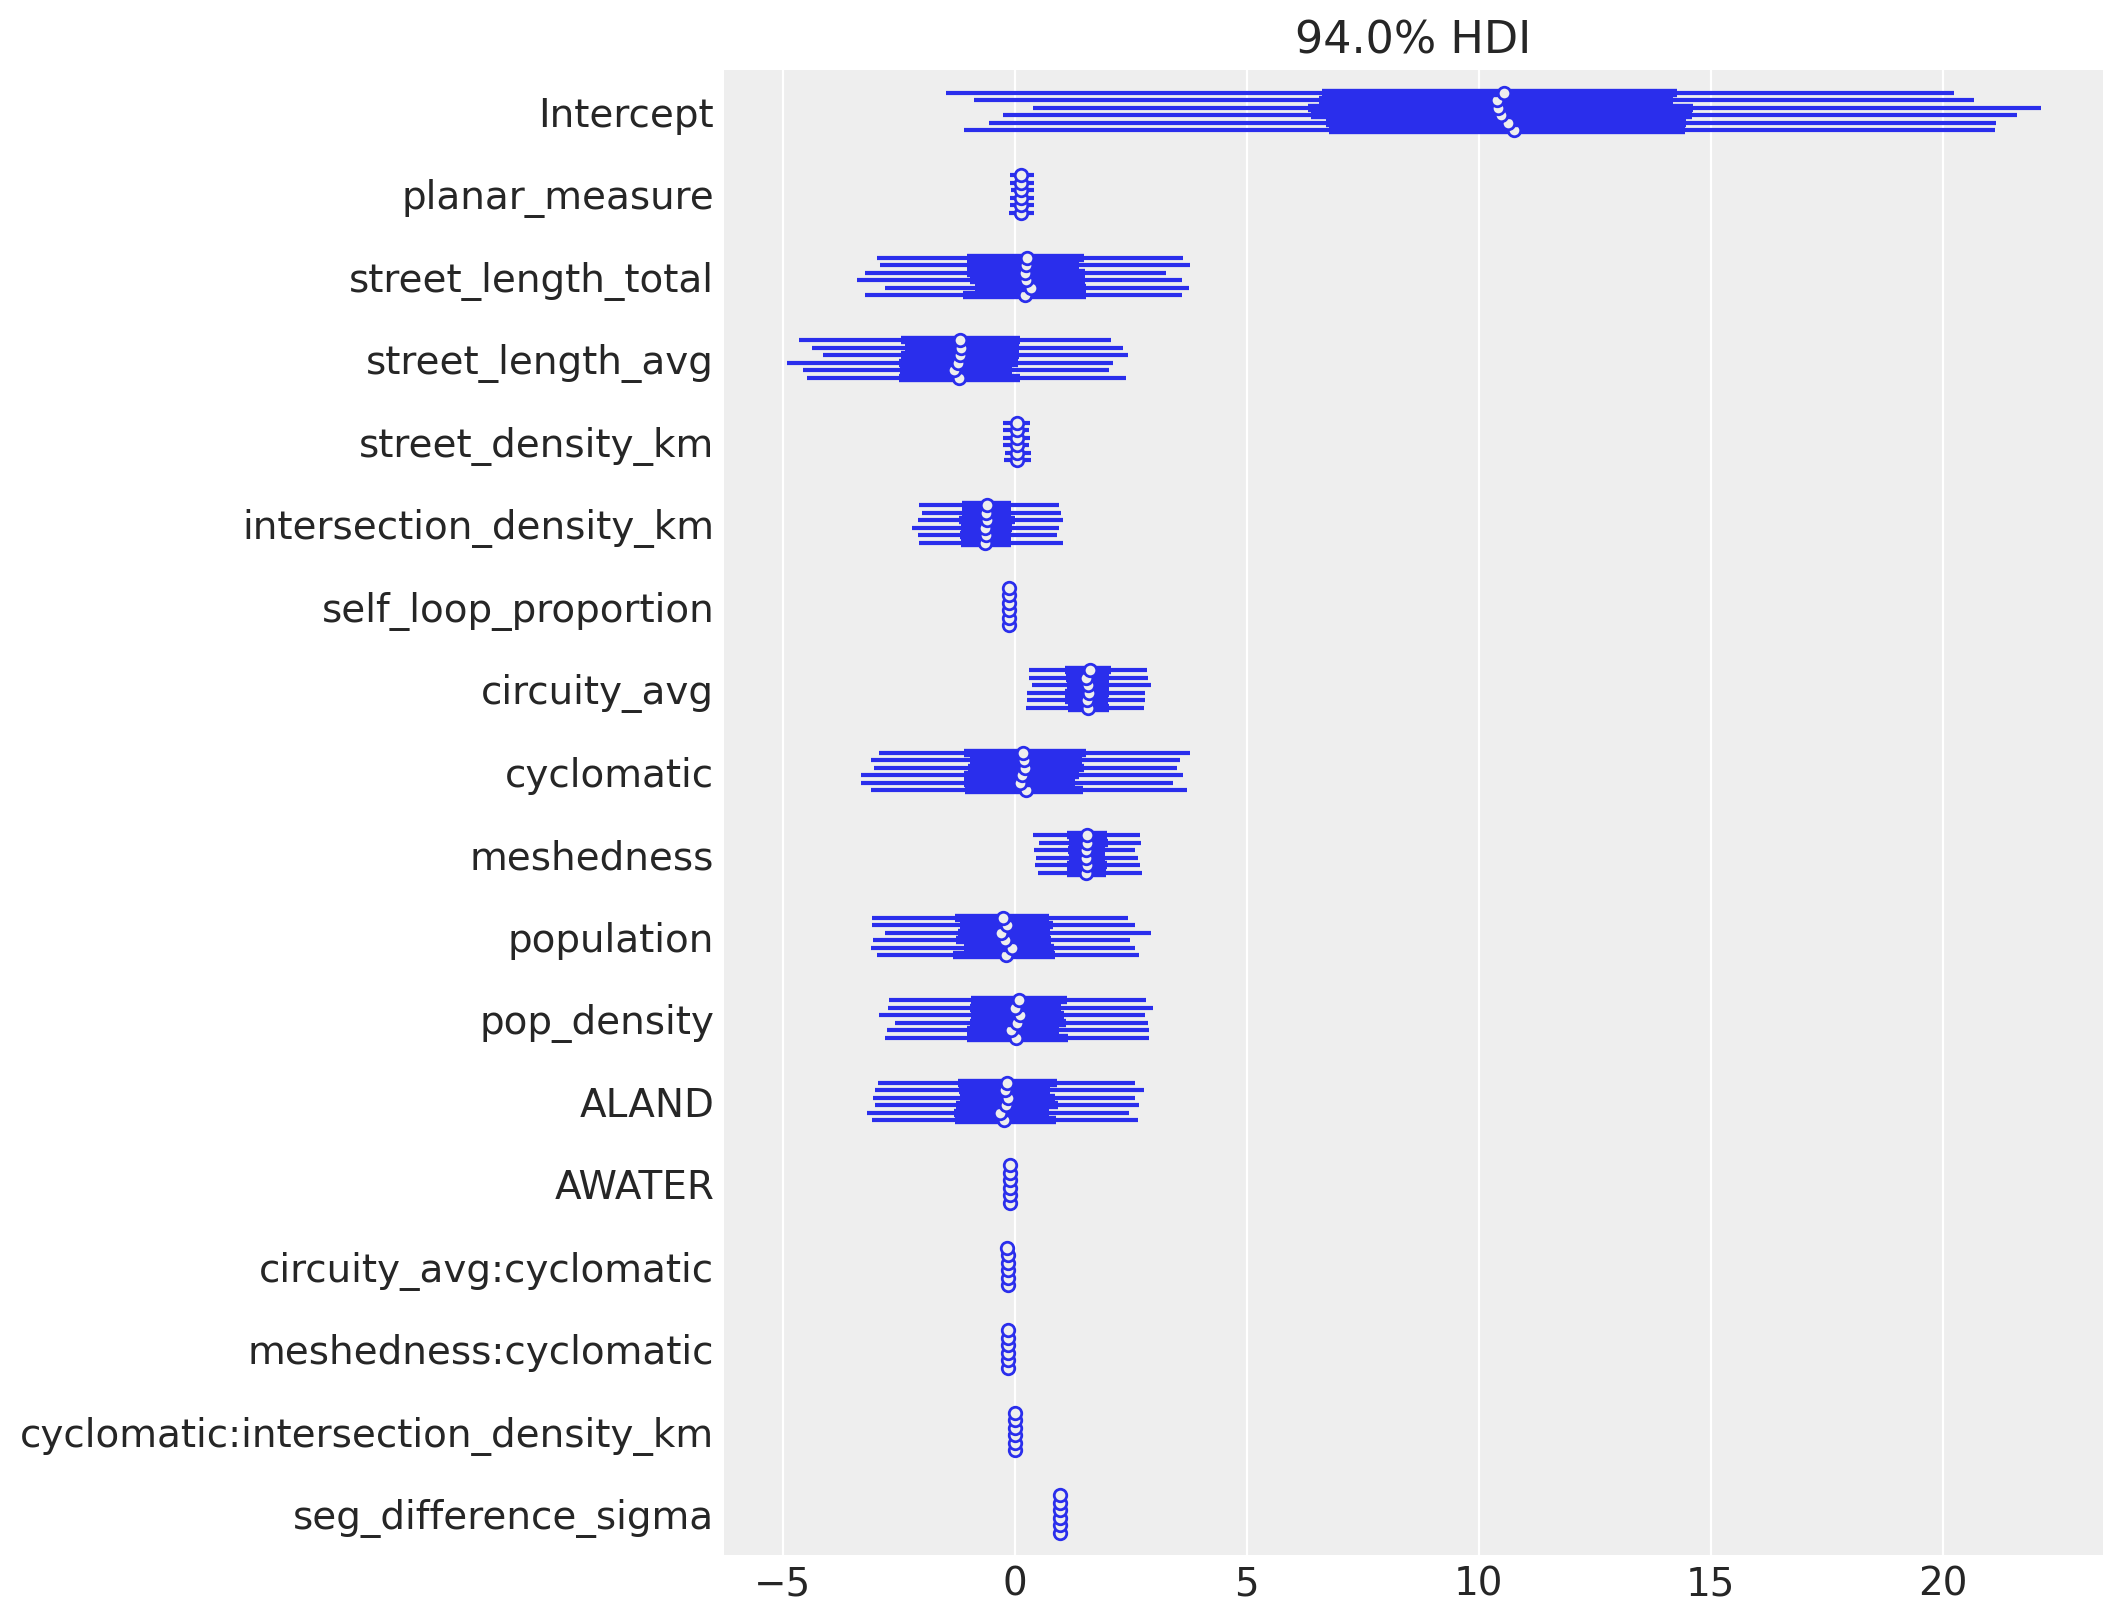

In [92]:
az.plot_forest(results,    figsize=(10.5, 8),
)

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'planar_measure'}>,
        <AxesSubplot:title={'center':'street_length_total'}>],
       [<AxesSubplot:title={'center':'street_length_avg'}>,
        <AxesSubplot:title={'center':'street_density_km'}>,
        <AxesSubplot:title={'center':'intersection_density_km'}>],
       [<AxesSubplot:title={'center':'self_loop_proportion'}>,
        <AxesSubplot:title={'center':'circuity_avg'}>,
        <AxesSubplot:title={'center':'cyclomatic'}>],
       [<AxesSubplot:title={'center':'meshedness'}>,
        <AxesSubplot:title={'center':'population'}>,
        <AxesSubplot:title={'center':'pop_density'}>],
       [<AxesSubplot:title={'center':'ALAND'}>,
        <AxesSubplot:title={'center':'AWATER'}>,
        <AxesSubplot:title={'center':'circuity_avg:cyclomatic'}>],
       [<AxesSubplot:title={'center':'meshedness:cyclomatic'}>,
        <AxesSubplot:title={'center':'cyclomatic:intersection_density_km'}>,
   

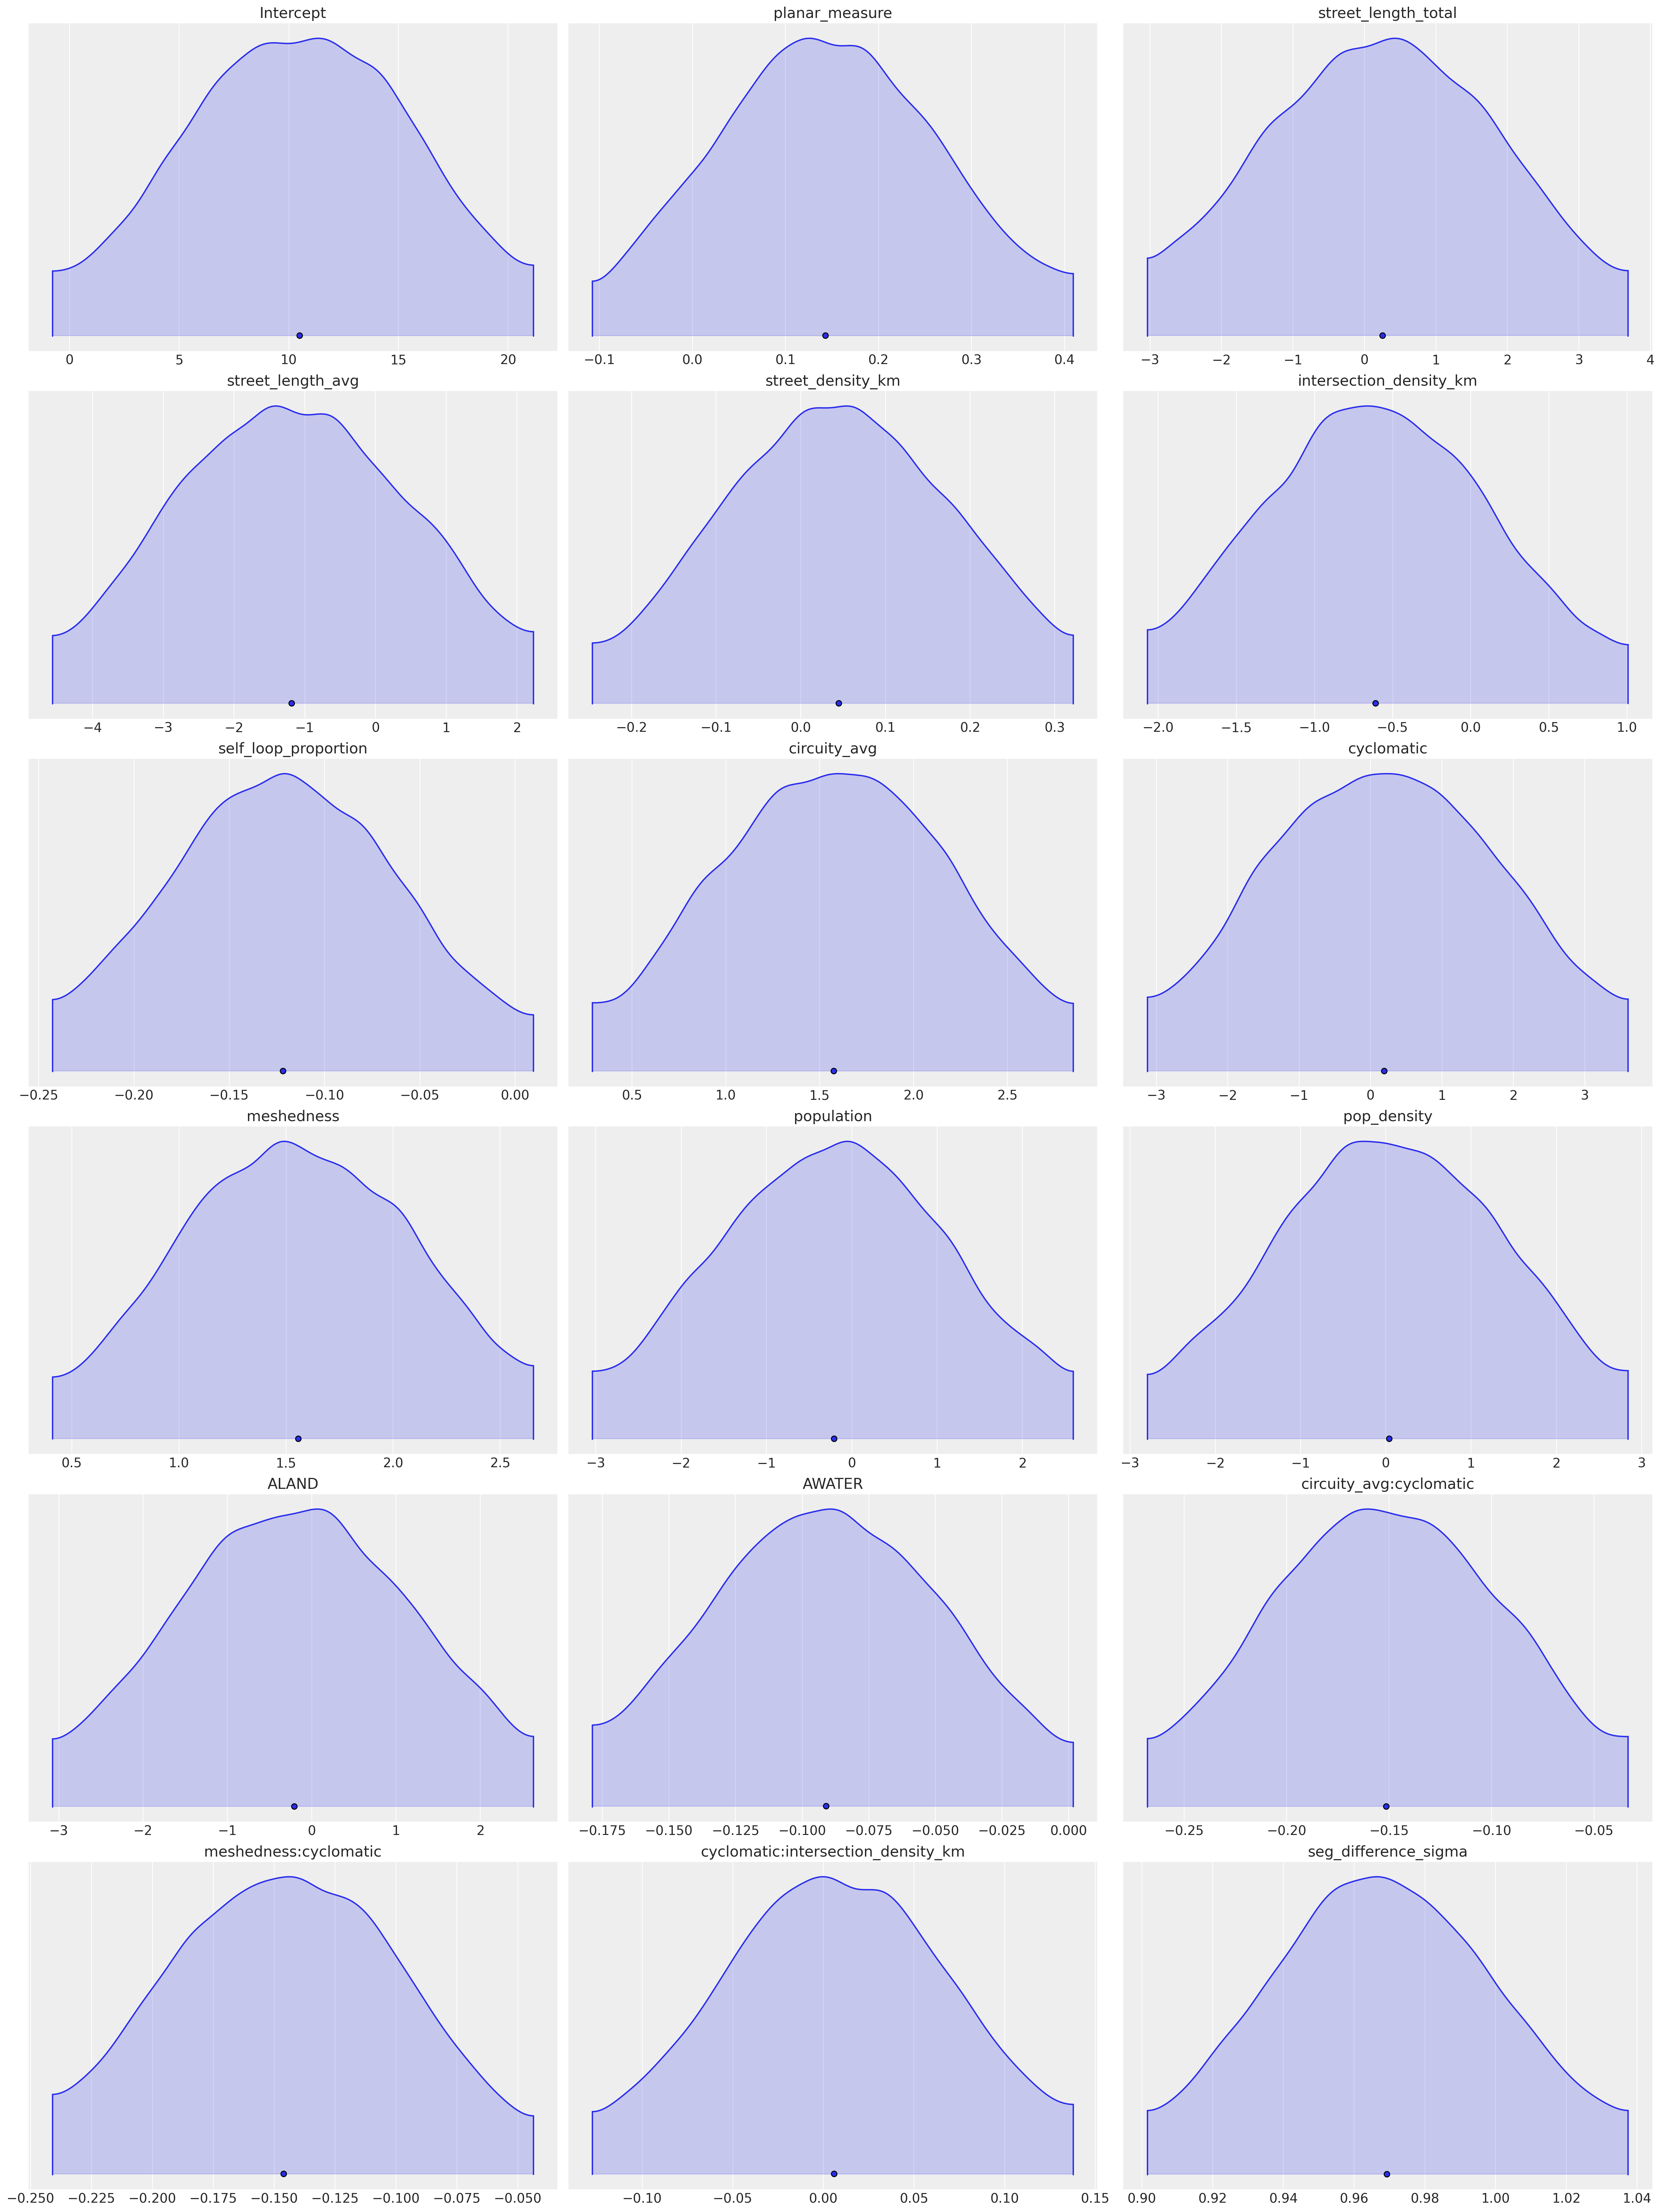

In [93]:
#az.style.use("arviz-doc")

az.plot_density(results, shade=0.2)

# $\Delta_{pct}$

In [102]:
form_pct_pure = (
    "pct_diff~ 1 + planar_measure + street_length_total + street_length_avg +"
    "intersection_density_km + self_loop_proportion +  circuity_avg + cyclomatic + meshedness  +"
    "ALAND + AWATER + circuity_avg*cyclomatic + cyclomatic*meshedness + cyclomatic*ALAND + ALAND*meshedness"
)

In [8]:
form_pct_pure_interaction = (
    "pct_diff ~ 1 + planar_measure + street_length_total + street_length_avg + street_density_km +"
    "intersection_density_km + self_loop_proportion +  circuity_avg  + node_props_3way  + node_props_4way + node_props_dead_end + cyclomatic + meshedness +"
    "population + pop_density + ALAND + AWATER + I(circuity_avg*cyclomatic)  + I(cyclomatic*street_length_total) + I(meshedness*cyclomatic) + I(node_props_dead_end*cyclomatic)"
)

In [103]:
model_pct = bmb.Model(form_pct_pure, df_transformed.drop(columns=['pct_diff']).join(df[['pct_diff']]))
results_pct = model_pct.fit(draws=2000, chains=6, inference_method='nuts_numpyro', cores=10)

Compiling...
Compilation time =  0:00:04.002271
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:12.408262
Transforming variables...
Transformation time =  0:00:00.005121
Computing Log Likelihood...
Log Likelihood time =  0:00:00.220295


In [27]:
model_pct_interaction = bmb.Model(form_pct_pure_interaction, df_transformed)
results_pct_interaction = model_pct_interaction.fit(draws=2000, chains=6, inference_method='nuts_blackjax', cores=10)

NameError: name 'form_pct_pure_interaction' is not defined

The model with the interaction fits better

In [104]:
az.summary(results_pct, round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.2714,106.2176,-199.8799,200.5946,1.1982,0.9341,7862.0820,8345.8746,1.0001
planar_measure,-18.2506,0.9916,-20.1545,-16.4157,0.0083,0.0058,14404.2257,8877.0305,1.0003
street_length_total,5.5349,20.0138,-33.0920,43.0076,0.2479,0.1926,6519.8593,7175.9155,1.0006
street_length_avg,-11.0642,20.0494,-50.2280,25.7444,0.2484,0.1902,6511.2766,7281.0913,1.0006
intersection_density_km,-2.9650,3.1505,-8.9141,2.9277,0.0351,0.0261,8063.8042,7906.0568,1.0004
self_loop_proportion,-0.7923,0.4683,-1.7006,0.0650,0.0038,0.0029,14998.1285,9502.3882,1.0004
circuity_avg,12.2919,5.3428,2.2034,22.1500,0.0606,0.0439,7794.8776,8174.3483,1.0005
cyclomatic,-0.3267,20.1066,-37.7695,38.5681,0.2441,0.1898,6787.1305,6830.6624,1.0004
meshedness,30.0962,9.0730,13.3871,47.6741,0.0971,0.0692,8735.6664,8121.1344,1.0002
ALAND,0.7473,5.3506,-9.6388,10.4279,0.0620,0.0477,7447.9827,7756.5082,1.0005


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

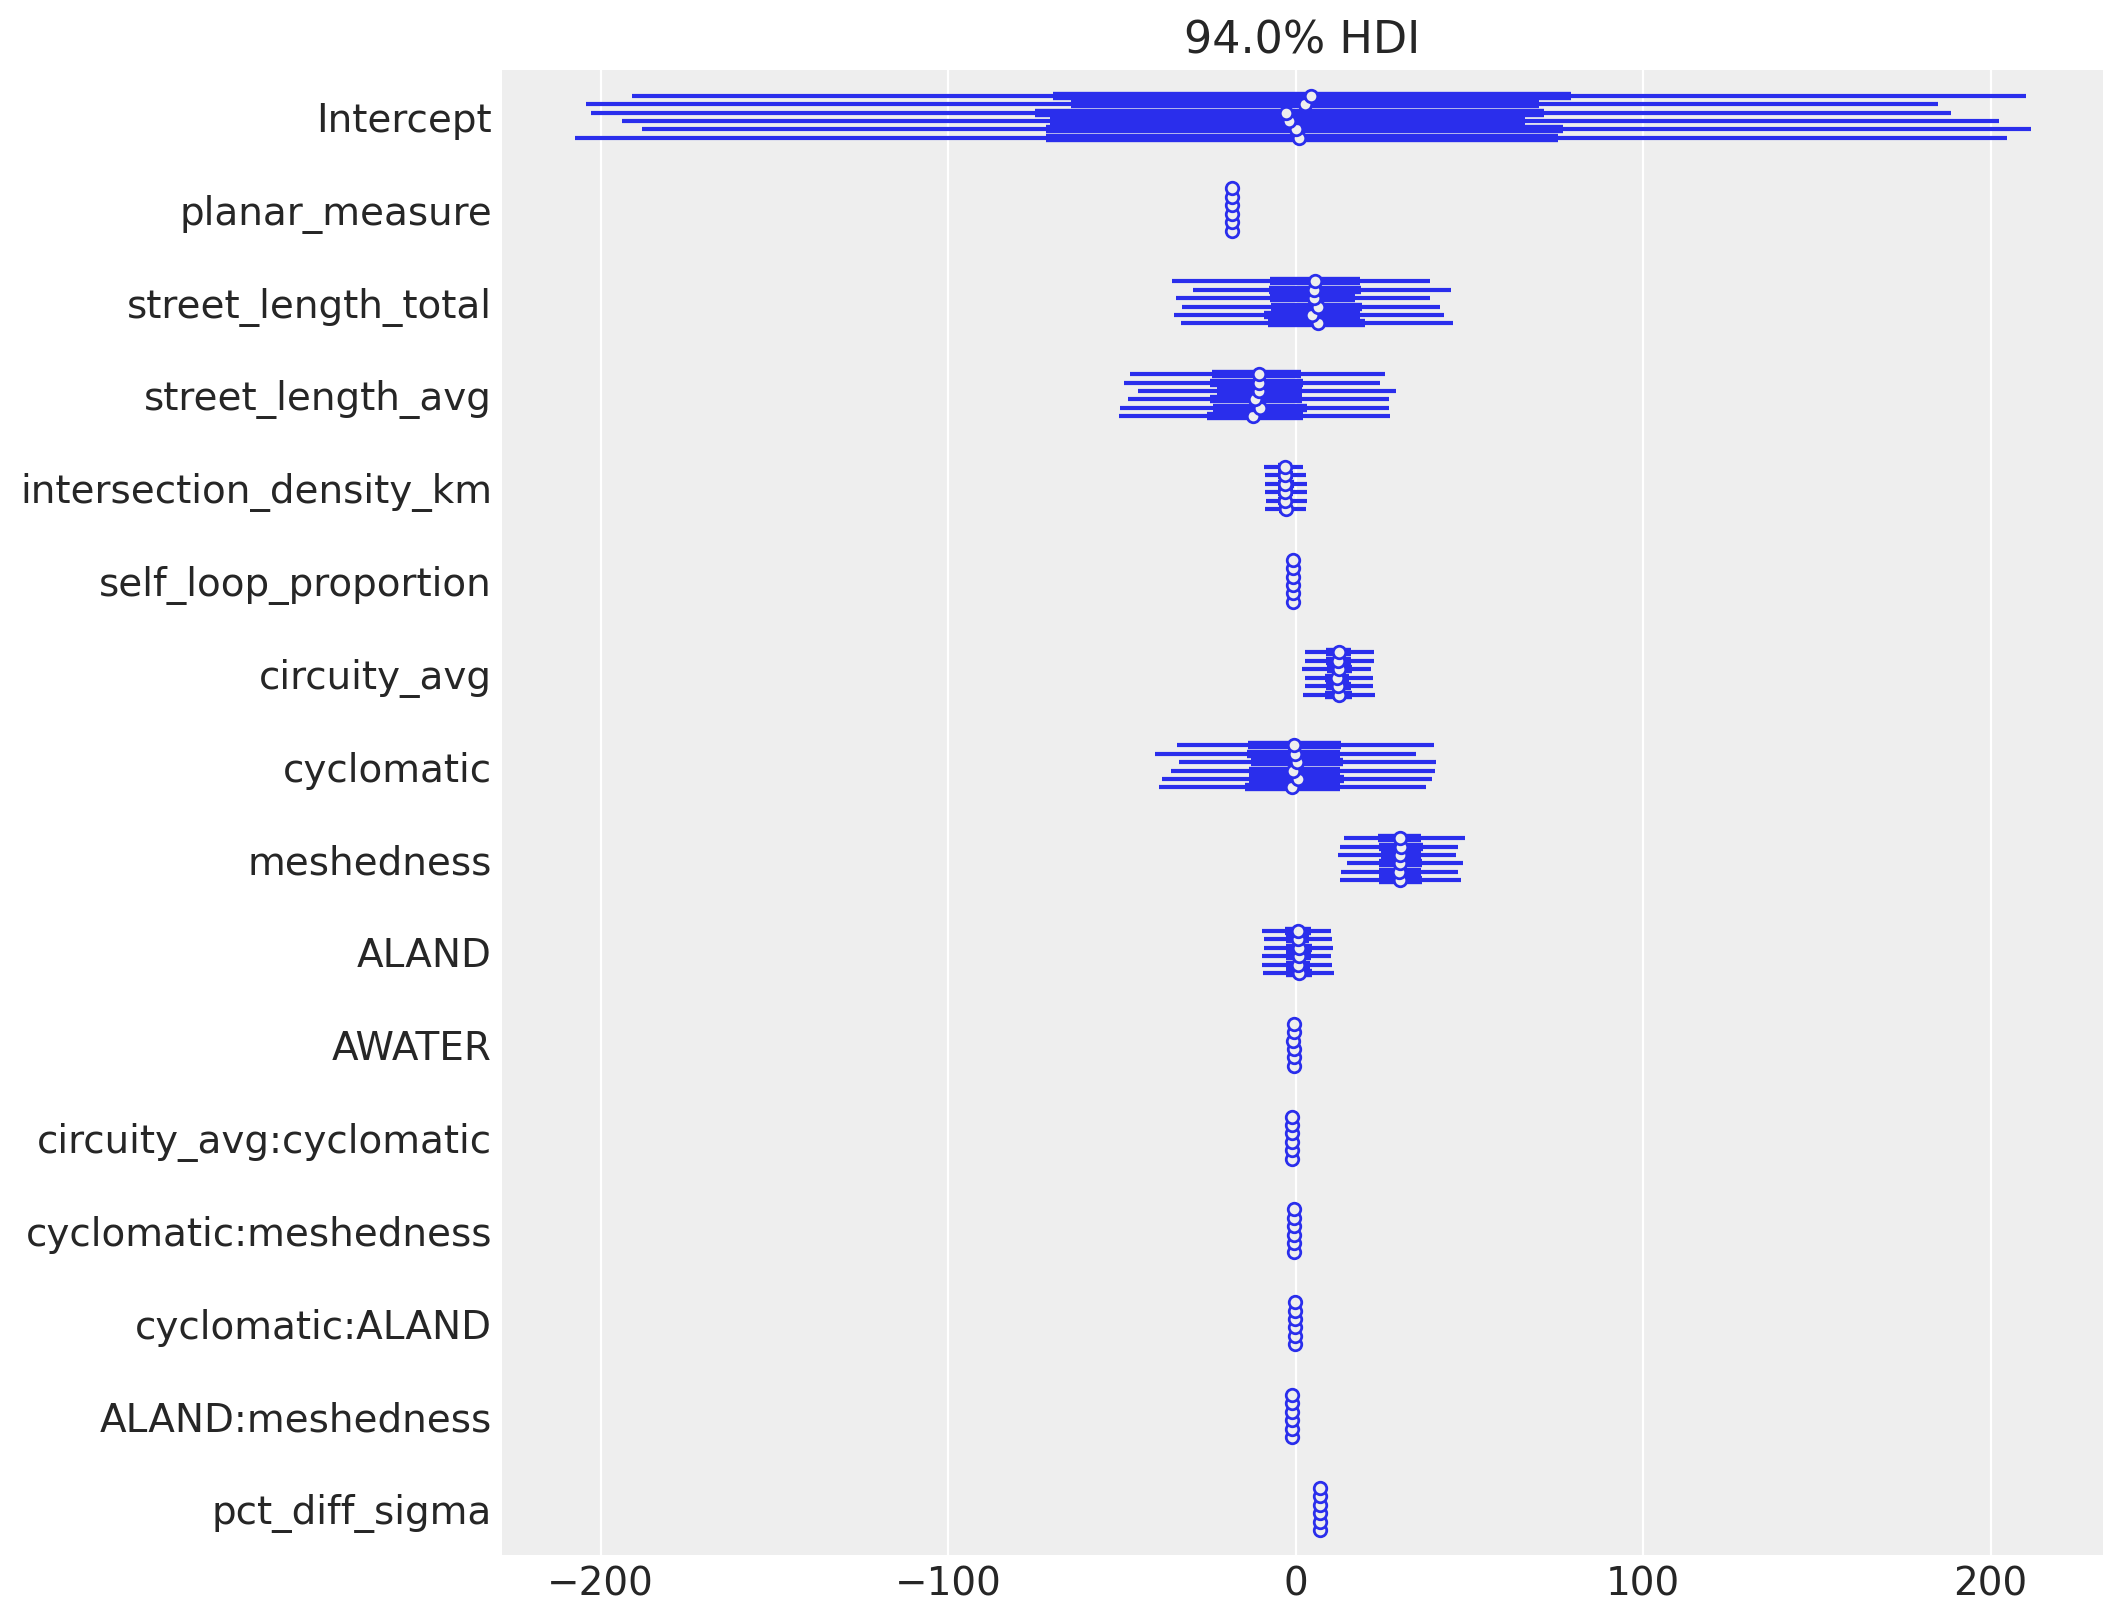

In [107]:
az.plot_forest(results_pct,    figsize=(10.5, 8),
)

In [106]:
results_pct?

Type:           InferenceData
String form:   
Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
Length:         4
File:           ~/mambaforge/envs/seg_networks/lib/python3.9/site-packages/arviz/data/inference_data.py
Docstring:     
Container for inference data storage using xarray.

For a detailed introduction to ``InferenceData`` objects and their usage, see
:ref:`xarray_for_arviz`. This page provides help and documentation
on ``InferenceData`` methods and their low level implementation.
Init docstring:
Initialize InferenceData object from keyword xarray datasets.

Parameters
----------
attrs : dict
    sets global attribute for InferenceData object.
kwargs :
    Keyword arguments of xarray datasets

Examples
--------
Initiate an InferenceData object from scratch, not recommended. InferenceData
objects should be initialized using ``from_xyz`` methods, see :ref:`data_api` for more
details.

.. ipython::

    In [1]: import arviz as az
       

In [337]:
df.pct_change

Index(['planar_measure', 'network_measure', 'streets_per_node_avg',
       'street_length_total', 'street_segment_count', 'street_length_avg',
       'street_density_km', 'circuity_avg', 'intersection_count',
       'intersection_density_km', 'self_loop_proportion', 'node_props_4way',
       'cyclomatic', 'ALAND', 'AWATER', 'population', 'pop_density',
       'seg_difference', 'node_props_dead_end', 'node_props_3way',
       'meshedness', 'k_avg', 'gamma'],
      dtype='object')

<AxesSubplot:>

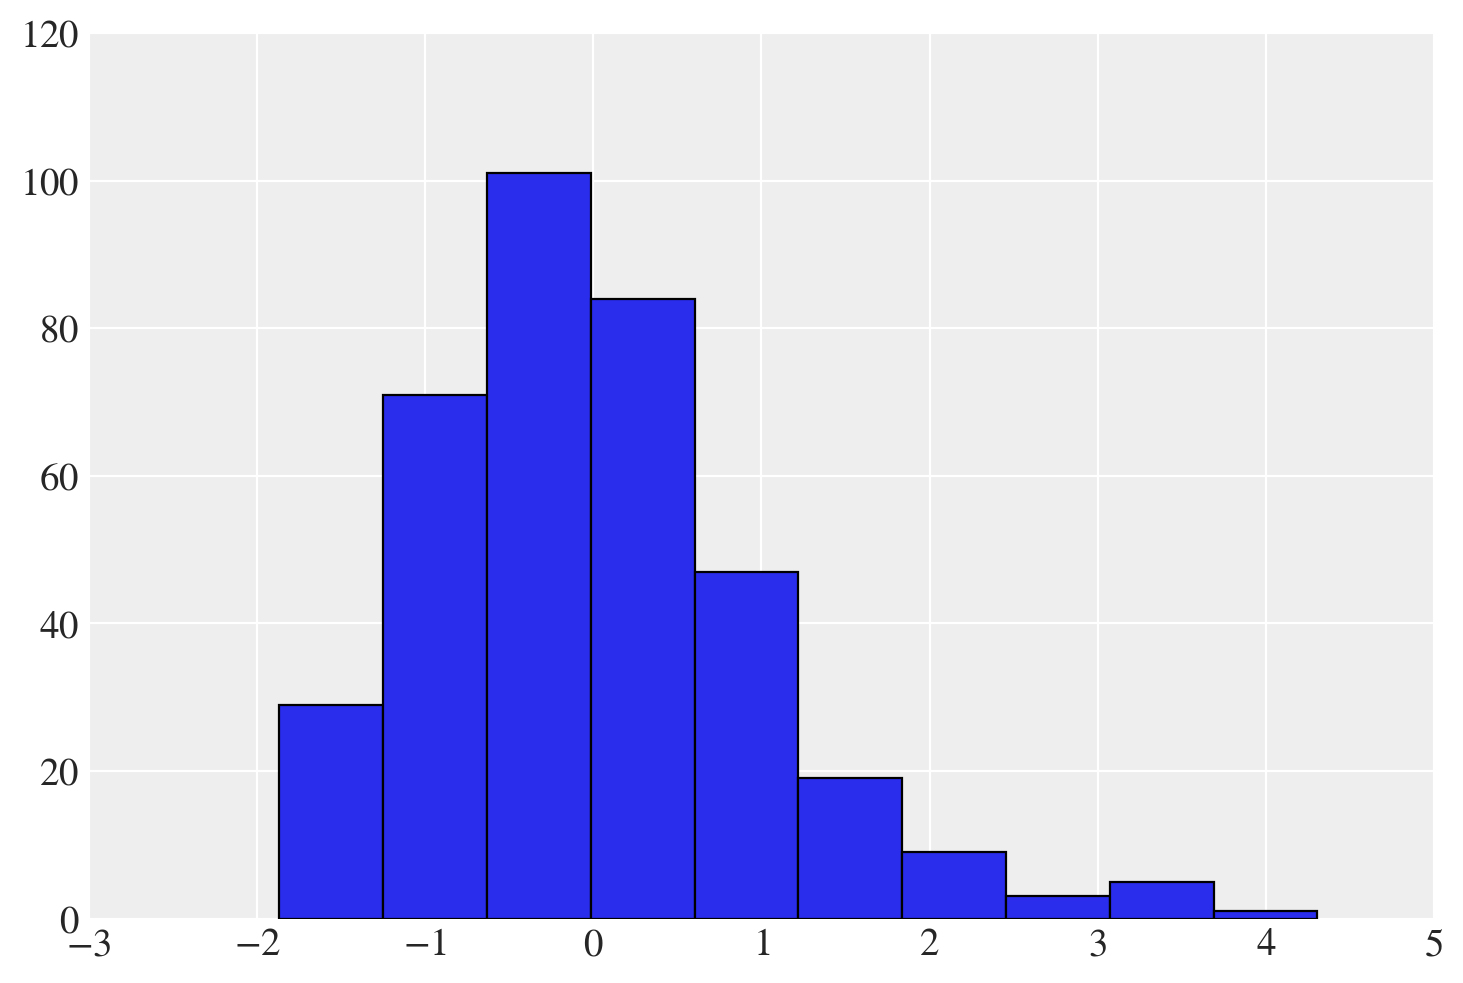

In [532]:
df_transformed.self_loop_proportion.hist()